In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

from sklearn.preprocessing import StandardScaler


seed = 331

In [3]:
def resultPlot(x_name, x, fnr, fpr, roc_auc, sensitivities, specificities, scale=1, marker=None):
    fig = plt.figure(figsize = (5, 5))
    
    colors = ['r', 'g', 'b', 'c', 'm']

    plt.plot(x, fnr, color=colors[0], marker=marker, label ='FNR')
    plt.plot(x, fpr, color=colors[1], marker=marker, label ='FPR')
    plt.plot(x, roc_auc, color=colors[2], marker=marker, label ='ROC AUC')
    plt.plot(x, sensitivities, color=colors[3], marker=marker, label ='Sensitivity')
    plt.plot(x, specificities, color=colors[4], marker=marker, label ='Specificity')

    # # Adding Xticks
    plt.xlabel(x_name, fontweight ='bold', fontsize = 15)
    plt.ylabel('Value', fontweight ='bold', fontsize = 15)
    if scale > 1:
        plt.xticks([x[i] for i in range(0,len(x),scale)])
    else:
        plt.xticks(x)

    plt.grid()
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", borderaxespad=0.)
    plt.show()

In [4]:
def fnr_calc(y_test, y_pred):
    tp, fn, fp, tn = confusion_matrix(y_test, y_pred, labels=[1,0]).ravel()
    return fn / (fn + tp)

def fpr_calc(y_test, y_pred):
    tp, fn, fp, tn = confusion_matrix(y_test, y_pred, labels=[1,0]).ravel()
    return fp / (fp + tn)



def model_metrics(y_test, y_pred):
    tp, fn, fp, tn = confusion_matrix(y_test, y_pred, labels=[1,0]).ravel()
    
    fnr = fn / (fn + tp)
    fpr = fp / (fp + tn)
    
    roc_auc = roc_auc_score(y_test, y_pred)
    
    sensitivity = tp / (tp + fn)
    specificity = tn / (tp + tn)
    
    return fnr, fpr, roc_auc, sensitivity, specificity

# Data preparation

In [5]:
dataframe = pd.read_csv("./data/creditcard.csv")

columns = dataframe.columns.drop('Class')

dataframe.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
scaled_dataframe = dataframe.copy().drop(['Class'],axis=1)

transformer = StandardScaler()

transformer.fit(scaled_dataframe)

scaled_dataframe = transformer.transform(scaled_dataframe)
scaled_dataframe = pd.DataFrame(scaled_dataframe, columns=columns)

In [7]:
X = scaled_dataframe
y = dataframe.Class

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=seed, test_size=0.33)

print("train rows: {}, test rows: {}".format(X_train.shape[0], X_test.shape[0]))

train rows: 190820, test rows: 93987


# Testing Decision Tree classifier

In [8]:
dt = DecisionTreeClassifier(random_state=seed)
dt.fit(X_train, y_train)


dt.score(X_test, y_test)

0.9993616138402119

In [9]:
y_pred = dt.predict(X_test)

In [10]:
cm = confusion_matrix(y_test, y_pred, labels=[1,0])
cm

array([[  129,    28],
       [   32, 93798]], dtype=int64)

In [11]:
fnr, fpr, roc_auc, sensitivity, specificity = model_metrics(y_test, y_pred)

print("FNR = {:.4f}%, FPR = {:.4f}%".format(fnr * 100, fpr * 100))
print("ROC AUC = {:.4f}".format(roc_auc * 100))
print("sensitivity = {:.4f}%, specificity = {:.4f}%".format(sensitivity * 100, specificity * 100))

FNR = 17.8344%, FPR = 0.0341%
ROC AUC = 91.0658
sensitivity = 82.1656%, specificity = 99.8627%


## Testing other Decision Tree settings

In [12]:
max_depth = np.linspace(1, 32, 32).astype(int)

fnrs_1 = []
fprs_1 = []
roc_aucs_1 = []
sensitivities_1 = []
specificities_1 = []

for max_depth_param in max_depth:
    dt = DecisionTreeClassifier(max_depth=max_depth_param, random_state=seed)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    fnr, fpr, roc_auc, sensitivity, specificity = model_metrics(y_test, y_pred)
    fnrs_1.append(fnr)
    fprs_1.append(fpr)
    roc_aucs_1.append(roc_auc)
    sensitivities_1.append(sensitivity)
    specificities_1.append(specificity)

In [13]:
min_fnr = 100
best_param = 0
for i in range(len(fnrs_1)):
    if (fprs_1[i] * 100 < 0.5 and fnrs_1[i] < min_fnr):
        min_fnr = fnrs_1[i]
        best_param = i
        
print("FNR = {:.4f}%, FPR = {:.4f}%".format(fnrs_1[best_param] * 100, fprs_1[best_param] * 100))
print("ROC AUC = {:.4f}".format(roc_aucs_1[best_param] * 100))
print("sensitivity = {:.4f}%, specificity = {:.4f}%".format(sensitivities_1[best_param] * 100, specificities_1[best_param] * 100))

print("Best max_depth = {:.2f}".format(max_depth[best_param]))

best_p = max_depth[best_param]

dt = DecisionTreeClassifier(max_depth=best_p, random_state=seed)
dt.fit(X_train, y_train)
y_pred_best = dt.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best, labels=[1,0])
cm

FNR = 17.8344%, FPR = 0.0171%
ROC AUC = 91.0743
sensitivity = 82.1656%, specificity = 99.8627%
Best max_depth = 12.00


array([[  129,    28],
       [   16, 93814]], dtype=int64)

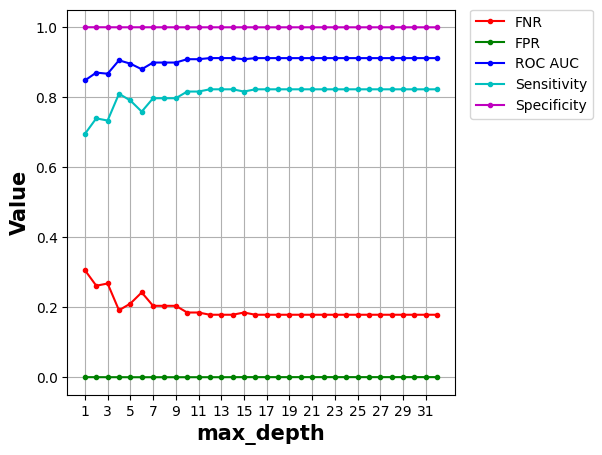

In [23]:
resultPlot('max_depth', max_depth, fnrs_1, fprs_1, roc_aucs_1, sensitivities_1, specificities_1, scale=2, marker='.')

In [15]:
min_samples_split = np.linspace(2, 10, 9, endpoint=True).astype(int)

fnrs_2 = []
fprs_2 = []
roc_aucs_2 = []
sensitivities_2 = []
specificities_2 = []

for min_samples_split_param in min_samples_split:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split_param, random_state=seed)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    fnr, fpr, roc_auc, sensitivity, specificity = model_metrics(y_test, y_pred)
    fnrs_2.append(fnr)
    fprs_2.append(fpr)
    roc_aucs_2.append(roc_auc)
    sensitivities_2.append(sensitivity)
    specificities_2.append(specificity)

In [16]:
min_fnr = 100
best_param = 0
for i in range(len(fnrs_2)):
    if (fprs_2[i] * 100 < 0.5 and fnrs_2[i] < min_fnr):
        min_fnr = fnrs_2[i]
        best_param = i
        
print("FNR = {:.4f}%, FPR = {:.4f}%".format(fnrs_2[best_param] * 100, fprs_2[best_param] * 100))
print("ROC AUC = {:.4f}".format(roc_aucs_2[best_param] * 100))
print("sensitivity = {:.4f}%, specificity = {:.4f}%".format(sensitivities_2[best_param] * 100, specificities_2[best_param] * 100))

print("Best min_samples_split = {:.2f}".format(min_samples_split[best_param]))

best_p = min_samples_split[best_param]

dt = DecisionTreeClassifier(min_samples_split=best_p, random_state=seed)
dt.fit(X_train, y_train)
y_pred_best = dt.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best, labels=[1,0])
cm

FNR = 17.8344%, FPR = 0.0341%
ROC AUC = 91.0658
sensitivity = 82.1656%, specificity = 99.8627%
Best min_samples_split = 2.00


array([[  129,    28],
       [   32, 93798]], dtype=int64)

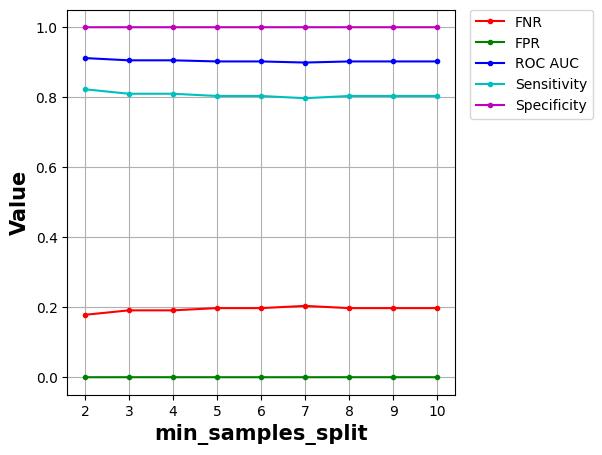

In [24]:
resultPlot('min_samples_split', min_samples_split, fnrs_2, fprs_2, roc_aucs_2, sensitivities_2, specificities_2, marker='.')

In [18]:
max_features = list(range(1,31))

fnrs_3 = []
fprs_3 = []
roc_aucs_3 = []
sensitivities_3 = []
specificities_3 = []

for max_features_param in max_features:
    dt = DecisionTreeClassifier(max_features=max_features_param, random_state=seed)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    fnr, fpr, roc_auc, sensitivity, specificity = model_metrics(y_test, y_pred)
    fnrs_3.append(fnr)
    fprs_3.append(fpr)
    roc_aucs_3.append(roc_auc)
    sensitivities_3.append(sensitivity)
    specificities_3.append(specificity)

In [19]:
min_fnr = 100
best_param = 0
for i in range(len(fnrs_3)):
    if (fprs_3[i] * 100 < 0.5 and fnrs_3[i] < min_fnr):
        min_fnr = fnrs_3[i]
        best_param = i
        
print("FNR = {:.4f}%, FPR = {:.4f}%".format(fnrs_3[best_param] * 100, fprs_3[best_param] * 100))
print("ROC AUC = {:.4f}".format(roc_aucs_3[best_param] * 100))
print("sensitivity = {:.4f}%, specificity = {:.4f}%".format(sensitivities_3[best_param] * 100, specificities_3[best_param] * 100))

print("Best max_features = {:.2f}".format(max_features[best_param]))

best_p = max_features[best_param]

dt = DecisionTreeClassifier(max_features=best_p, random_state=seed)
dt.fit(X_train, y_train)
y_pred_best = dt.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best, labels=[1,0])
cm

FNR = 17.8344%, FPR = 0.0384%
ROC AUC = 91.0636
sensitivity = 82.1656%, specificity = 99.8627%
Best max_features = 12.00


array([[  129,    28],
       [   36, 93794]], dtype=int64)

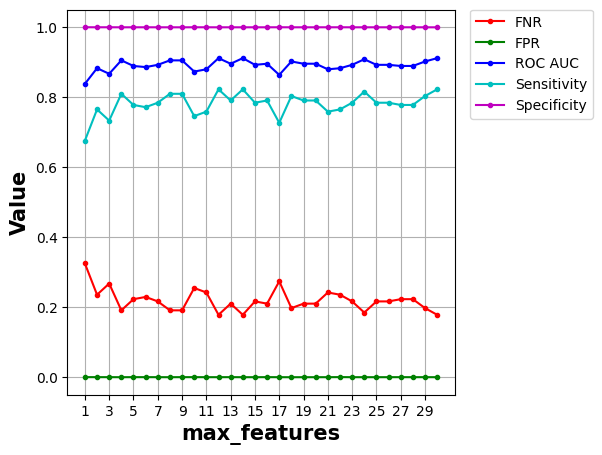

In [25]:
resultPlot('max_features', max_features, fnrs_3, fprs_3, roc_aucs_3, sensitivities_3, specificities_3, scale=2, marker='.')